# Fast, Broadcasted Mueller Polarimetry

`katsu` was built in part to understand the spatially-varying polarized response of optics. Manufacturing errors can leave phase and amplitude aberrations in an optical beam, and understanding these sources of error is critical to understanding our system.

To spatially resolve this data, we need to be able to do full polarimetry on an array of pixels - so a naive implementation of the algorithm will take a very long time to run. Here, we show off the numpy optimizations done to speed up the polarimetric data reduction for Full Mueller Polarimetry.

Readers should first be familiar with the Full Mueller Polarimetry demo

_written by Jaren Ashcraft_

In [1]:
from katsu.polarimetry import (
    broadcast_kron,
    broadcast_outer
)

from katsu.mueller import (
    linear_polarizer,
    linear_retarder,
    linear_diattenuator
)

import numpy as np
from time import perf_counter

Polarimetric data reduction boils down to matrix multiplications and Kronecker products. Numpy is already configured to broadcast matrix multiplications, just stuff the matrix dimensions into the final two axes of the numpy array! But `np.kron` is a more general operation that operates on tensors of arbritrary dimension. A naive implementation of looping over the broadcasted dimensions would look like the following:

In [2]:
array_of_matrices = np.random.random([128,128,2,2])
array_out_naive = np.zeros([128, 128, 4, 4])

t1 = perf_counter()
for i in range(array_of_matrices.shape[0]):
    for j in range(array_of_matrices.shape[1]):

        array_out_naive[i,j] = np.kron(array_of_matrices[i,j], array_of_matrices[i,j])

runtime_naive = perf_counter() - t1
print(runtime_naive,'s to compute naive kronecker')

0.30755750000000015 s to compute naive kronecker


This is perfectly acceptable, but may scale unfavorably for large datasets that are highly sampled. In contrast, the implementation in `katsu.polarimetry` has configured the kronecker product using `np.einsum`, which batches the computation in the broadcast dimensions. 

In [3]:
array_out = np.zeros([128, 128, 4, 4])

t1 = perf_counter()
array_out = broadcast_kron(array_of_matrices, array_of_matrices)
runtime_broadcast = perf_counter() - t1
print(runtime_broadcast,'s to compute broadcast kronecker')
print(runtime_naive / runtime_broadcast,'x relative speedup from naive implementation')

0.006013199999999941 s to compute broadcast kronecker
51.14705980176997 x relative speedup from naive implementation


Just by virtue of a more specialized implementation, we can achieve runtime increases two orders of magnitude greater than the looped case. Furthermore, the results are functionally identical. Below we plot the difference of the elements of the matrix as a function of the first two array dimensions and observe that the results are entirely zero.

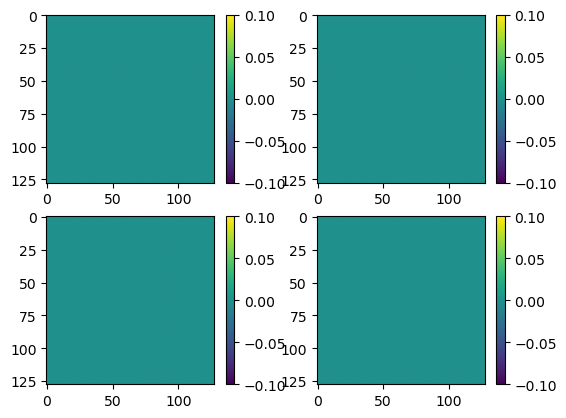

In [4]:
import matplotlib.pyplot as plt
difference = (array_out_naive - array_out) 

def plot_square(x,n=2,vmin=None,vmax=None):
    k = 1
    plt.figure()
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax)
            plt.colorbar()
            k += 1
    plt.show()

plot_square(difference)

This is a no-compromise method of doing broadcasted kronecker products for Mueller matrices, and is our default for Mueller polarimetry in `katsu`, which we demonstrate below. We begin by constructing a simple Mueller Matrix. It is composed of a linear polarizer and retarder oriented at random angles.

In [5]:
M_simple = linear_retarder(np.random.random(),np.random.random()) @ linear_diattenuator(np.random.random(),np.random.random())
print('Mueller Matrix')
print(M_simple)

Mueller Matrix
[[ 0.88803481  0.11154679  0.00967043  0.        ]
 [ 0.1111027   0.88068034  0.04405154 -0.10428341]
 [ 0.01232293  0.04422123  0.62152964  0.62286986]
 [ 0.00636707  0.1046849  -0.62283505  0.61418867]]


We now need to extend it to a spatial dimension, let's maintain the size of the previous example

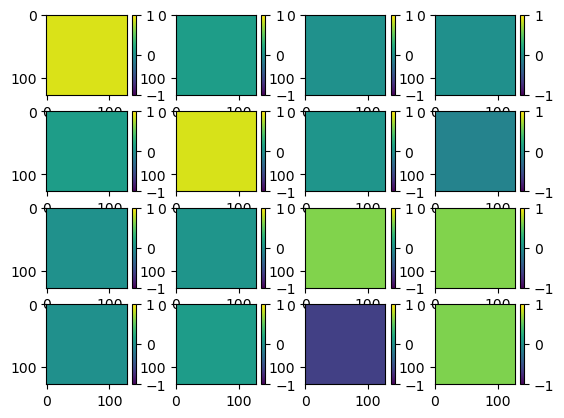

In [6]:
M_spatial = np.broadcast_to(M_simple,[128,128,*M_simple.shape])
plot_square(M_spatial, n=4, vmin=-1, vmax=1)

Now we create a noisy array and subtract it from each element of `M_spatial`

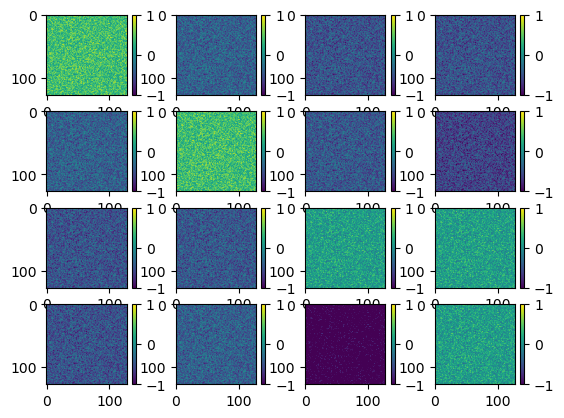

In [7]:
# Now we will add a little bit of noise to each element
noisy_mask = np.random.random([128,128])
M_noisy = M_spatial - noisy_mask[..., np.newaxis, np.newaxis]
plot_square(M_noisy, n=4, vmin=-1, vmax=1)

Okay we've cooked up our Jones Matrix with spatial variation, but can we detect it? First we need to create our synthetic power measurement, and for that - we need a Mueller matrix model of our system. We begin by constructing the Mueller matrix for the polarization state generator `Mg` and the analyzer `Ma`.

In the below cell we are showing a little bit of how `broadcast_mueller_polarimetry` works, so there's a lot of shape manipulation of numpy arrays in order to broadcast the operations. This is just to make the code faster, so feel free to pay it no mind.

In [8]:
starting_angles={'psg_polarizer':0,
                'psg_qwp':0,
                'psa_qwp':0,
                'psa_polarizer':0}

nmeas = 26
thetas = np.linspace(0,2*np.pi,nmeas)

psg_qwp = linear_retarder(starting_angles['psg_qwp']+thetas,np.pi/2, shape=[128, 128, nmeas])
psg_hpl = linear_polarizer(starting_angles['psg_polarizer'], shape=[128, 128, nmeas])

psa_qwp = linear_retarder(starting_angles['psa_qwp']+thetas*5,np.pi/2, shape=[128,128, nmeas])
psa_hpl = linear_polarizer(starting_angles['psa_polarizer'], shape=[128, 128, nmeas]) 


Mg =  psg_qwp @ psg_hpl
Ma = psa_hpl @ psa_qwp

Now we compute the mueller matrix of the total system `Msys`

In [9]:
# reshape noisy array for matrix multiplication
M_noisy_broadcast = np.broadcast_to(M_noisy,[nmeas, *M_noisy.shape])
M_noisy_broadcast = np.moveaxis(M_noisy_broadcast,0,2)

# compute the system Mueller matrix
Msys = Ma @ M_noisy_broadcast @ Mg

Since the first optic is a polarizer, it truly doesn't matter what polarization is incident on `Msys`, it all gets converted to linear polarization. Consequently, we can consider multiplying `Msys` by a Stokes vector equal to $S = [1, 0, 0, 0]$ to retrieve the measured flux. This means that we measure the top-left element of the Mueller Matrix $M_{sys,0,0}$ or, in numpy...

In [10]:
power_measured = Msys[...,0,0]

Now it's time to hop over to `katsu.polarimetry` to retrieve the `broadcasted_full_mueller_polarimetry` function to see if we can retrieve a Mueller matrix from the measured power. This function takes in the angles that we rotate the PSG quarter wave plate at, the power measured, and the starting angles dictionary we defined above, to derive the Full Mueller matrix of the measurement.

In [22]:
from katsu.polarimetry import broadcasted_full_mueller_polarimetry

t1 = perf_counter()
M_meas = broadcasted_full_mueller_polarimetry(thetas, power_measured, starting_angles=starting_angles)
print(perf_counter() - t1,'s to construct the Mueller Matrix')

1.8931718999999987 s to construct the Mueller Matrix


Great, so the data reduction part takes about 2 seconds to process 16k Mueller matrices over 26 measurements! We can get a visual sense of the difference between the injected `M_noisy` and retrieved `M_meas` by plotting their difference, which we do below:

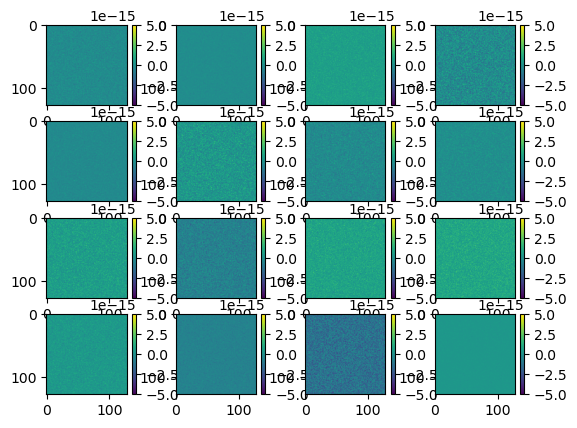

In [23]:
plot_square(M_noisy - M_meas, n=4, vmin=-5e-15, vmax=5e-15)

Please note that the scale of these plots is on the order of $\pm 10^{-15}$, meaning that we've recovered the Mueller matrix to _femto-scale_ precision, which is essentially our machine precision.

In [24]:
print('Machine Epsilon = ',np.finfo(float).eps)

Machine Epsilon =  2.220446049250313e-16


Of course, this precision means nothing in the presence of real noise sources so all we've learned is that `katsu` introduces a totally vectorized approach to Mueller polarimetry with absolutely no compromises to accuracy. In the next tutorial we will show how this can be applied in a laboratory setting.